# Parameters, data load and initial conditioning.

First, we add all the necessary packages.

In [14]:
using Pkg
Pkg.activate(".")

using PythonCall,CondaPkg
JEft=pyimport("justetf_scraping")

using CairoMakie
using Serialization, CSV, DataFrames, Dates
using Statistics, CovarianceEstimation, Random
using LinearAlgebra 
using NLopt

include("src/src.jl")

  Activating project at `~/Codes/portfolio`


get_R_RR_cor (generic function with 1 method)

Parameters:
- `shift`: a period of time in days over which all the returns will be evaluated.
- `risk_free_return`: the return over `shift` period of time considered risk free, e.g. bank deposit.
- `half_life`: to compute mean return over `shift` period we use weighted means. The data at the day `today-half_life` will have weight two times smaller than the data from `today`.
- `correlation_threshold`: at some moment we will filter our tickers so that no tickers with correlation above the given threshold are left. For faster results use lower threshold!
- `update_charts_q`: if `true`, the fresh charts from justETF will be downloaded (this will take around 30 minutes). If `false`, the charts will be loaded from the data folder. If there is no charts there, charts will be loaded from justETF.
- `data_starting_date`: ETS that don't have data earlier than this will be thrown away.
- `available_tickers_file`: location of the file that lists the tickers we have an access to. If `nothing`, all tickers from the justETF website will be considered available. The file should be a table with "isin" column.

In [15]:
shift=365;
risk_free_return=0.037;
half_life=4;
correlation_threshold=0.9;
update_charts_q=false;
data_starting_date=Date(2019);
available_tickers_file="data/Trading212AvailableInstruments.csv";

We create two tables with data:
 - `DO` stands for "Data Overview". There, each row corresponds to a particular ticker. Contains some general information.
 - `DC` stands for "Data Charts". There, the first column contains all the dates and the rest of the columns corresponds to values of tickers.

In [16]:

tmp=JEft.load_overview(strategy="epg-longOnly")
tmp.to_csv("tmp.csv")
DO=CSV.read("tmp.csv", DataFrame)
rm("tmp.csv");

if update_charts_q
    DC=up_to_date_charts(DO)
else
    if isfile("data/charts.csv")
        DC=CSV.read("data/charts.csv", DataFrame)
    else
        DC=up_to_date_charts(DO)
    end
end

tickers_consistent_with_DC=DO.isin .|> x-> x in names(DC)
if !all(tickers_consistent_with_DC)
    println("Attention, new tickets in the overview table. The database is outdated. Ignore, or update the database.")
end

/home/nikolay/Codes/portfolio/.CondaPkg/env/lib/python3.11/site-packages/justetf_scraping/overview.py:407: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({"Yes": True, "No": False}).astype("bool")
/home/nikolay/Codes/portfolio/.CondaPkg/env/lib/python3.11/site-packages/justetf_scraping/overview.py:407: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({"Yes": True, "No": False}).astype("bool")


Now, we create the conditioned tables `DO_acc` and `DC_acc`. In these tables we have only accumulating ETFs with the fund size of at least 50 millions euro. Furthermore, we throw away ETFs which don't have data at least up to `data_starting_date` unless we can compensate it using the data from distributing ETF version.

In [17]:
conditions=(DO.dividends.=="Accumulating") .& (DO.size .|> x -> ismissing(x) ? false : x>=50 ) .& tickers_consistent_with_DC

DO_acc=DO[conditions,:]
DC_acc=DC[:,["date",DO_acc.isin...]]


tickers_to_remove=Vector{Int}()
for i=2:length(names(DC_acc))
    tk=names(DC_acc)[i]
    tk_vals=DC_acc[!,tk]

    tk_first_day_index=findfirst(x->!(ismissing(x)),tk_vals)

    if DC_acc[tk_first_day_index,"date"]>data_starting_date
        tk_dist_name=dist_name(DO[DO.isin.==tk,:name]...)
        tk_dist=begin tmp = DO[DO.name.==tk_dist_name,:isin]; length(tmp)>0 ? tmp[1] : nothing end
        
        if !(isnothing(tk_dist))
            tk_dist_vals=DC[!,tk_dist]
            tk_dist_first_day_index=findfirst(x->!(ismissing(x)),tk_dist_vals)
            if DC[tk_dist_first_day_index,"date"] <= data_starting_date
                DC_acc[!,tk].=DC[!,tk_dist]
                println("Data in $tk was replaced with data in $(tk_dist)")
            end
            println("$tk does not have enough data and its distributing version does not have it either. $tk will be removed from the database.")
            push!(tickers_to_remove,i-1)
        else
            println("$tk does not have enough data and there is no distributing version of it to compensate. $tk will be removed from the database.")
            push!(tickers_to_remove,i-1)
        end
    else
        println("$tk has enough data")
    end
end

println("Removing tickers with not enough data")
DO_acc=DO_acc[Not(tickers_to_remove),:]
DC_acc=DC_acc[:,["date",DO_acc.isin...]];


if !isnothing(available_tickers_file)
    println("Removing unavailable tickers")

    available_tickers=CSV.read(available_tickers_file, DataFrame).isin

    availability_filter=DO_acc.isin .|> x-> x ∈ available_tickers

    DO_acc=DO_acc[availability_filter,:]
    DC_acc=DC_acc[:,["date",DO_acc.isin...]];
end;

IE00B5BMR087 has enough data
IE00B4L5Y983 has enough data
IE00B3YCGJ38 has enough data
IE00BKM4GZ66 has enough data
Data in IE00BFMXXD54 was replaced with data in IE00B3XXRP09
IE00BFMXXD54 does not have enough data and its distributing version does not have it either. IE00BFMXXD54 will be removed from the database.
IE00B53SZB19 has enough data
IE00B6R52259 has enough data
IE00B4ND3602 has enough data
IE00B579F325 has enough data
Data in IE00BK5BQT80 was replaced with data in IE00B3RBWM25
IE00BK5BQT80 does not have enough data and its distributing version does not have it either. IE00BK5BQT80 will be removed from the database.
IE00BJ0KDQ92 has enough data
DE000A0S9GB0 has enough data
IE00BLNMYC90 has enough data
IE00BGSF1X88 does not have enough data and there is no distributing version of it to compensate. IE00BGSF1X88 will be removed from the database.
IE00BF4G7076 has enough data
LU0290358497 has enough data
IE00B3WJKG14 has enough data
IE00BFY0GT14 does not have enough data and ther

Let us take a random ticker and plot its behavior to compare with the website.

ticker: IE00B8X9NW27


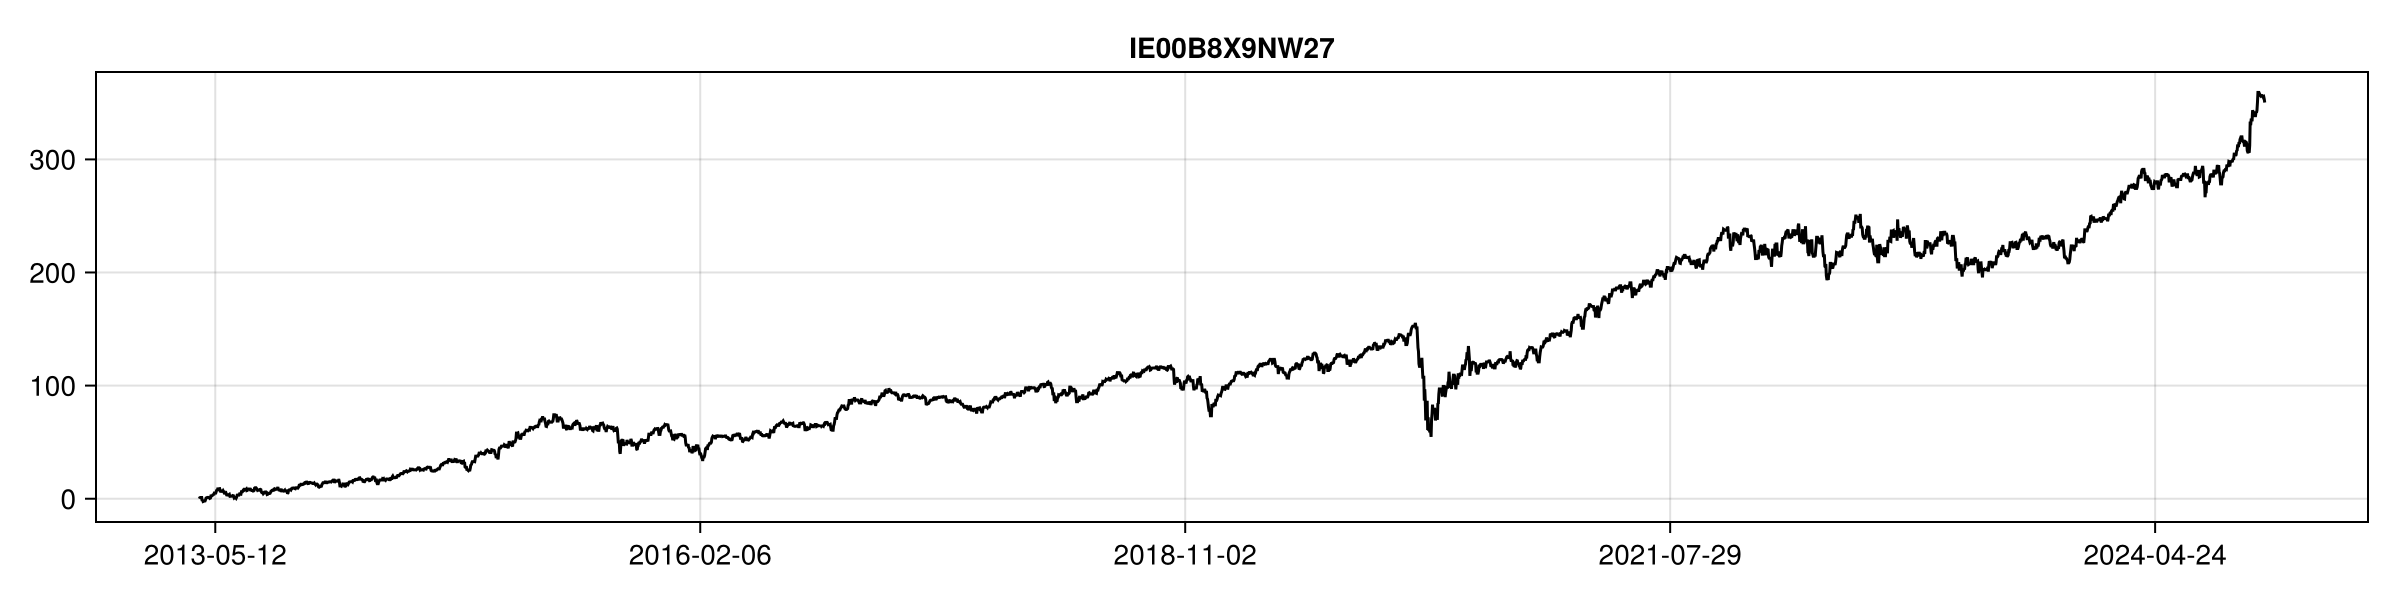

In [18]:
tk=rand(names(DC_acc)[2:end])
println("ticker: ", tk)
fig=Figure(;size=(1200,300))
ax=Axis(fig[1,1], title=tk)
lines!(ax,DC_acc[!,:date],DC_acc[!,tk].-100; color=:black)
fig

# Decorrelation

Now, we will reduce the number of tickers further by dividing them into highly correlated groups and choosing only one ticker from each group (the one with the highest Sharpe ratio). For this, we will need compute the expectation values `R` and covariance matrix `RR` of the annual returns. We also compute the correlation matrix `cor`, which is a normalized version of the covariance matrix. We will use `cor` to distinguish the correlated assets and `R`, `RR` to compute the Sharpe ratio. 

We compute the covariance matrix by using so called shrinkage estimators. I don't know much about these and use the method here more or less blindly. The idea is that if we don't have a lot of data point (comparing with the number of tickers) then the standard method can be unstable. Shrinkage estimators are supposed to make the result a bit more reliable.

In [19]:
R,RR,cor=get_R_RR_cor(DC_acc, shift, half_life);
cor

395×395 Matrix{Float64}:
  1.0         0.957672   0.971129   …   0.764445   0.353333   0.583893
  0.957672    1.0        0.957317       0.835226   0.370617   0.608622
  0.971129    0.957317   1.0            0.763628   0.352457   0.583365
  0.77592     0.830465   0.77498        0.729612   0.114391   0.42061
  0.745646    0.73743    0.746025       0.551244  -0.23885    0.352036
  0.9496      0.96656    0.949177   …   0.836968   0.348298   0.602731
 -0.071318   -0.16265   -0.0695663     -0.403445  -0.402884  -0.235738
 -0.0723137  -0.16391   -0.0705453     -0.404781  -0.405895  -0.238227
  0.95759     0.968975   0.957256       0.835159   0.368907   0.608599
 -0.0685197  -0.160583  -0.0667614     -0.403064  -0.405205  -0.238104
  ⋮                                 ⋱                        
  0.290198    0.327412   0.289067       0.241598  -0.339163  -0.010732
  0.532679    0.505819   0.53221        0.363166   0.814726   0.354607
  0.867863    0.882469   0.867707       0.714222   0.276411   

We have now correlation matrix, let us look at how tickers with correlations above certain threshold behave. The following cell will chose a random ticker, take `nsample` tickers whose correlation with it lies inside the `correlation_interval` and plot their behavior. The red line is the chosen ticker and the gray lines is the correlated tickers. To make the comparison simpler, all the lines are shifted so that the last point is at zero.

In [20]:
correlation_interval=[0.9,1.0]
nsample=100

i=rand(1:size(DO_acc,1))
tk=names(DC_acc)[i+1]

println("chosen ticker: $tk")

tk_cor=cor[:,i]

if count(tk_cor .|> (x-> x>correlation_interval[1] && x<correlation_interval[2]))>1

    correlated_tickers=names(DC_acc)[2:end][tk_cor .|> (x-> x>correlation_interval[1] && x<correlation_interval[2])]
    correlation_values=tk_cor[tk_cor .|> (x-> x>correlation_interval[1] && x<correlation_interval[2])]

    correlation_color=(correlation_values.-findmin(correlation_values)[1])./(findmax(correlation_values)[1]-findmin(correlation_values)[1])
    println("amount of tickers in the correlation interval: $(length(correlated_tickers))")

    fig=Figure(;size=(1800,450))
    ax=Axis(fig[1,1], title="price")

    for i in 1:min(nsample,length(correlated_tickers))
        tkc=correlated_tickers[i]    
        sh=collect(skipmissing(DC_acc[:,tkc]))[end]
        lines!(ax,DC_acc[!,"date"], DC_acc[!,tkc].-sh,color=(:black, (correlation_color[i])))
    end

    sh=collect(skipmissing(DC_acc[:,tk]))[end]
    lines!(ax,DC_acc[!,"date"], DC_acc[!,tk].-sh, color=:red)
    
    ax=Axis(fig[1,2], title="relative return over $shift days")


    for i in 1:min(nsample,length(correlated_tickers))
        tkc=correlated_tickers[i]    
        lines!(ax, DC_acc[(1+shift):end,"date"] ,percent_return(DC_acc[:,tkc],shift),color=(:black, (correlation_color[i])))
    end

    lines!(ax,DC_acc[(1+shift):end,"date"], percent_return(DC_acc[!,tk],shift), color=:red)

    color_range = (minimum(correlation_values),maximum(correlation_values))
    cmap = :grays

    cbar = Colorbar(fig[1,3], colormap=Reverse(cmap), limits=color_range,
    flipaxis=true, label="Correlation")


    fig 
else
    println("Ticker is not correlated with other tickers in the given correlation interval, please try again.")
end


chosen ticker: IE00B3VWN179
Ticker is not correlated with other tickers in the given correlation interval, please try again.


The cell below runs the correlation reducing procedure resulting in the data collection `DC_acc_cr` such that non of two tickers in `DC_acc_cr` are correlated above `correlation_theshold`. After the procedure is done, we also define the data collection `DO_acc_cr` with general information about tickers from `DC_acc_cr`. 

In [21]:
DC_acc_cr=copy(DC_acc)
R,RR,cor=get_R_RR_cor(DC_acc_cr, shift, half_life);

while length(cor[cor.>correlation_threshold])>size(cor,1)
    R,RR,cor=get_R_RR_cor(DC_acc_cr, shift, half_life)
    println("number of tickers: ", size(cor,1))


    cnt=1
    ct_filter=(cor[:,cnt].>correlation_threshold)
    while cnt<=length(R)
        ct_filter=(cor[:,cnt].>correlation_threshold)
        if count(ct_filter)>1
            break
        end
        cnt+=1
    end

    if cnt>length(R)
        break
    end

    correlated_tickers_ind=findall(x->x==true, ct_filter)

    sharpe_ratios=[]
    for tk ∈ correlated_tickers_ind
        push!(sharpe_ratios,(R[tk]-risk_free_return)/(sqrt(RR[tk,tk])))
    end
    best_ticker_ind=correlated_tickers_ind[findmax(sharpe_ratios)[2]]
    
    filter!(x->x!=best_ticker_ind,correlated_tickers_ind)

    tickers_to_remove=names(DC_acc_cr)[2:end][correlated_tickers_ind]

    DC_acc_cr=DC_acc_cr[!,Not(tickers_to_remove)]
end

DO_acc_cr=DO_acc[DO_acc.isin .|> (x->x ∈ names(DC_acc_cr)), :]

number of tickers: 395
number of tickers: 352
number of tickers: 325
number of tickers: 311
number of tickers: 303
number of tickers: 278
number of tickers: 274
number of tickers: 243
number of tickers: 236
number of tickers: 233
number of tickers: 230
number of tickers: 221
number of tickers: 213
number of tickers: 211
number of tickers: 197
number of tickers: 195
number of tickers: 194
number of tickers: 192
number of tickers: 188
number of tickers: 187
number of tickers: 186
number of tickers: 184
number of tickers: 181
number of tickers: 176
number of tickers: 175
number of tickers: 173
number of tickers: 171
number of tickers: 170
number of tickers: 168
number of tickers: 166
number of tickers: 165
number of tickers: 162
number of tickers: 155
number of tickers: 154
number of tickers: 149
number of tickers: 147
number of tickers: 143
number of tickers: 140
number of tickers: 139
number of tickers: 138
number of tickers: 137
number of tickers: 136
number of tickers: 133
number of t

Row,isin,wkn,ticker,valor,name,inception_date,age_in_days,age_in_years,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,is_sustainable,number_of_holdings,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2023,2022,2021,2020,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk,max_drawdown,last_year_max_drawdown,last_three_years_max_drawdown,last_five_years_max_drawdown
,String15,String7?,String7,String15?,String,Date,Int64,Float64,String15,String15,String3,Bool,Bool,String15,Float64,String31,Int64?,Bool,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64?,Float64?
1,DE000A0S9GB0,A0S9GB,4GLD,missing,Xetra-Gold,2007-11-27,6221,17.0438,Long-only,Germany,EUR,false,false,Accumulating,0.0,Physically backed,13340,false,missing,34.02,-0.99,0.34,10.17,14.39,33.05,58.19,89.07,9.31,7.11,4.0,13.18,missing,missing,13.51,14.02,14.55,2.44,1.18,0.93,-36.79,-5.44,-12.7,-18.21
2,LU0290358497,DBX0AN,XEON,3220328,Xtrackers II EUR Overnight Rate Swap UCITS ETF 1C,2007-05-25,6407,17.5534,Long-only,Luxembourg,EUR,false,false,Accumulating,0.1,Swap based Unfunded,11458,false,missing,3.58,0.08,0.28,0.85,1.8,3.84,6.9,5.67,3.27,-0.03,-0.58,-0.57,missing,missing,0.15,0.17,0.17,25.59,13.04,6.71,-3.7,0.0,-0.4,-1.54
3,IE00B3WJKG14,A142N1,QDVE,30453015,iShares S&P 500 Information Technology Sector UCITS ETF USD (Acc),2015-11-20,3306,9.05753,Long-only,Ireland,USD,false,true,Accumulating,0.15,Full replication,10020,false,69,46.36,3.33,4.86,24.23,17.81,50.35,75.98,231.07,52.08,-23.98,44.56,30.56,missing,missing,22.42,26.0,28.32,2.24,0.8,0.95,-31.62,-16.95,-26.68,-31.62
4,IE00B3VWN393,A0X8SH,SXRL,10200795,iShares USD Treasury Bond 3-7yr UCITS ETF (Acc),2009-06-03,5667,15.526,Long-only,Ireland,USD,false,true,Accumulating,0.07,Sampling,5488,false,90,7.59,0.02,2.45,3.51,5.91,6.5,3.76,6.8,0.87,-3.85,5.68,-2.02,missing,missing,6.85,9.64,8.65,0.95,0.13,0.15,-17.3,-3.15,-12.9,-13.62
5,IE00BZCQB185,A2AFCY,QDV5,31609599,iShares MSCI India UCITS ETF USD (Acc),2018-05-24,2390,6.54795,Long-only,Ireland,USD,false,false,Accumulating,0.65,Optimized sampling,5367,false,152,21.26,1.51,0.97,1.4,7.79,22.85,41.72,95.23,15.48,-2.89,35.69,5.15,missing,missing,15.93,15.49,20.4,1.43,0.8,0.7,-40.78,-7.64,-20.76,-40.78
6,IE00BYXYYP94,A2DN9V,IS09,36324506,iShares USD Short Duration Corporate Bond UCITS ETF (Acc),2017-04-13,2796,7.66027,Long-only,Ireland,USD,false,true,Accumulating,0.2,Sampling,4597,false,2689,9.55,-0.18,1.81,5.24,6.24,8.08,13.31,15.64,1.99,1.41,7.83,-4.56,missing,missing,6.34,8.33,7.72,1.27,0.51,0.38,-14.65,-2.77,-11.78,-11.78
7,IE00BYXPSP02,A2DN9Z,IS0F,36414884,iShares USD Treasury Bond 1-3yr UCITS ETF (Acc),2017-04-13,2796,7.66027,Long-only,Ireland,USD,false,true,Accumulating,0.07,Sampling,4158,false,91,8.38,0.0,1.53,4.95,5.58,6.85,10.88,12.29,0.62,2.32,7.47,-5.35,missing,missing,6.51,8.49,7.86,1.05,0.41,0.3,-15.11,-2.92,-13.38,-13.38
8,IE00BYXYYM63,A2DN9W,IS03,36329219,iShares US Aggregate Bond UCITS ETF (Acc),2017-04-13,2796,7.66027,Long-only,Ireland,USD,false,true,Accumulating,0.25,Sampling,4078,false,8945,7.5,0.19,2.99,3.82,6.39,7.28,0.19,4.03,1.91,-7.83,6.24,-1.84,missing,missing,7.53,10.33,9.24,0.96,0.01,0.09,-15.47,-3.46,-12.76,-14.71
9,IE00BZ043R46,A2DWBL,QDVJ,37977783,iShares Core Global Aggregate Bond UCITS ETF USD Hedged (Acc),2017-11-21,2574,7.05205,Long-only,Ireland,USD,true,true,Accumulating,0.1,Sampling,3898,false,15991,9.07,0.19,2.92,5.38,7.09,8.4,4.34,6.87,2.97,-5.99,6.37,-3.88,missing,missing,6.72,9.06,8.32,1.25,0.16,0.16,-12.24,-2.55,-12.24,-12.24


# Optimization

Before going to the optimization, let us define some parameters:
 - `USD_bound`: gives a constrain on the total amount of the USD based tickers
 - `entropy_factor`: we add entropy times `entropy_factor` into the objective function to improve diversification.
 - `lowest_share`: if not zero, the code will run optimization twice. In the second time, only tickers with share (in the previous solution) larger than `lowest_share` will be used.
 - `xtol_rel_1`: In the first optimization round, if the relative change of the weight vector after a step is less than `xtol_rel_1` the search stops
 - `xtol_rel_2`: In the second optimization round, if the relative change of the weight vector after a step is less than `xtol_rel_2` the search stops

In [22]:
USD_bound=0.5
entropy_factor=0.2;
lowest_share=0.01;
xtol_rel_1=1e-4;
xtol_rel_2=1e-6;

Now, let us proceed to the optimization. It is still semi-global. ISRES algorithm does not guaranties to find global optimum, but it tries to avoid local traps.

In [23]:
R,RR,cor=get_R_RR_cor(DC_acc_cr, shift, half_life)
USD_filter=DO_acc_cr.currency.=="USD"


function entropy(w)
    -sum((w).*log.(w))
end
function sharpe_ratio(w) 
    return (dot(R,w)-risk_free_return)/sqrt(dot(w,RR*w))
end
function objective(w, grad)
    if length(grad) > 0
        wCw_root=(dot(w,RR*w))^1/2
        grad.=R/wCw_root-(dot(R,w)-risk_free_return)*(RR*w)/(wCw_root)^3-entropy_factor*(log.(w).+1)
    end
    return sharpe_ratio(w)+entropy_factor*entropy(w)
end
function sum_constrain(w, grad)
    if length(grad) > 0
        grad.=1
    end
    return sum(w)-1
end
function USD_constrain(w,grad)
    if length(grad) > 0
        grad.=USD_filter
    end
    return sum(w[USD_filter])-USD_bound
end


opt = NLopt.Opt(:GN_ISRES, length(R))
NLopt.lower_bounds!(opt, zeros(length(R)))
NLopt.upper_bounds!(opt, ones(length(R)))
equality_constraint!(opt, sum_constrain, 1e-8)
inequality_constraint!(opt, USD_constrain, 1e-8)

NLopt.max_objective!(opt, objective)

NLopt.xtol_rel!(opt, xtol_rel_1)

w_opt=rand(length(R))
w_opt/=sum(w_opt)

max_f, w_opt, ret = NLopt.optimize!(opt, w_opt)
num_evals = NLopt.numevals(opt)

ret_risk_r=dot(R,w_opt)/sqrt(dot(w_opt,RR*w_opt))

println(
    """
    First round of optimization (ISRES):
    solution status           : $ret
    sum of weights            : $(sum(w_opt))
    USD share                 : $(sum(w_opt[USD_filter]))
    # function evaluation     : $num_evals
    -------------------------------------------------
    objective value           : $max_f
    entropy                   : $(entropy(w_opt))
    mean return               : $(dot(R,w_opt))
    mean risk                 : $(sqrt(dot(w_opt,RR*w_opt)))
    return/risk ratio         : $(ret_risk_r)
    """
)

low_share_filter=(w_opt.>=lowest_share)
if lowest_share!=0
    println("The optimization problem will be restricted to $(count(low_share_filter)) tickers with share more than $lowest_share")
    R=R[low_share_filter]
    RR=RR[low_share_filter,low_share_filter]
    w_opt=w_opt[low_share_filter]
    w_opt./=sum(w_opt)
    USD_filter=USD_filter[low_share_filter]

    DO_acc_cr=DO_acc_cr[low_share_filter,:]
    DC_acc_cr=DC_acc_cr[:,["date",DO_acc_cr.isin...]];
end

opt = NLopt.Opt(:GN_ISRES, length(R))

NLopt.lower_bounds!(opt, ones(length(R))*lowest_share)
NLopt.upper_bounds!(opt, ones(length(R)))
equality_constraint!(opt, sum_constrain, 1e-8)
inequality_constraint!(opt, USD_constrain, 1e-8)

NLopt.max_objective!(opt, objective)


NLopt.xtol_rel!(opt, xtol_rel_2)

max_f, w_opt, ret = NLopt.optimize!(opt, w_opt)
num_evals = NLopt.numevals(opt)

ret_risk_r=dot(R,w_opt)/sqrt(dot(w_opt,RR*w_opt))


println(
    """
    Second round of optimization (ISRES):
    solution status           : $ret
    sum of weights            : $(sum(w_opt))
    USD share                 : $(sum(w_opt[USD_filter]))
    # function evaluation     : $num_evals
    -------------------------------------------------
    objective value           : $max_f
    entropy                   : $(entropy(w_opt))
    mean return               : $(dot(R,w_opt))
    mean risk                 : $(sqrt(dot(w_opt,RR*w_opt)))
    return/risk ratio         : $(ret_risk_r)
    """
)

First round of optimization (ISRES):
solution status           : XTOL_REACHED
sum of weights            : 0.9999999959051863
USD share                 : 0.4999978707311966
# function evaluation     : 23208470
-------------------------------------------------
objective value           : 2.135178629590153
entropy                   : 2.517452864542009
mean return               : 0.11900891184653872
mean risk                 : 0.05026016554494763
return/risk ratio         : 2.367857537996152

The optimization problem will be restricted to 12 tickers with share more than 0.01
Second round of optimization (ISRES):
solution status           : XTOL_REACHED
sum of weights            : 1.0000000089096293
USD share                 : 0.4999999861357238
# function evaluation     : 313503
-------------------------------------------------
objective value           : 2.2482736230791422
entropy                   : 2.1400650577988247
mean return               : 0.1314075767040976
mean risk              

In [1]:
p=sortperm(w_opt; rev=true)
names_ordered=DO_acc_cr.name[p]
isin_ordered=DO_acc_cr.isin[p]
w_opt_ord=w_opt[p]
for i=1:length(w_opt_ord)
    println(names_ordered[i]," : ", isin_ordered[i], " | ", round(w_opt_ord[i]; digits=3))
end

UndefVarError: UndefVarError: `w_opt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Let us now look at the historical performance of this portfolio (with weights rounded to 3 digits).

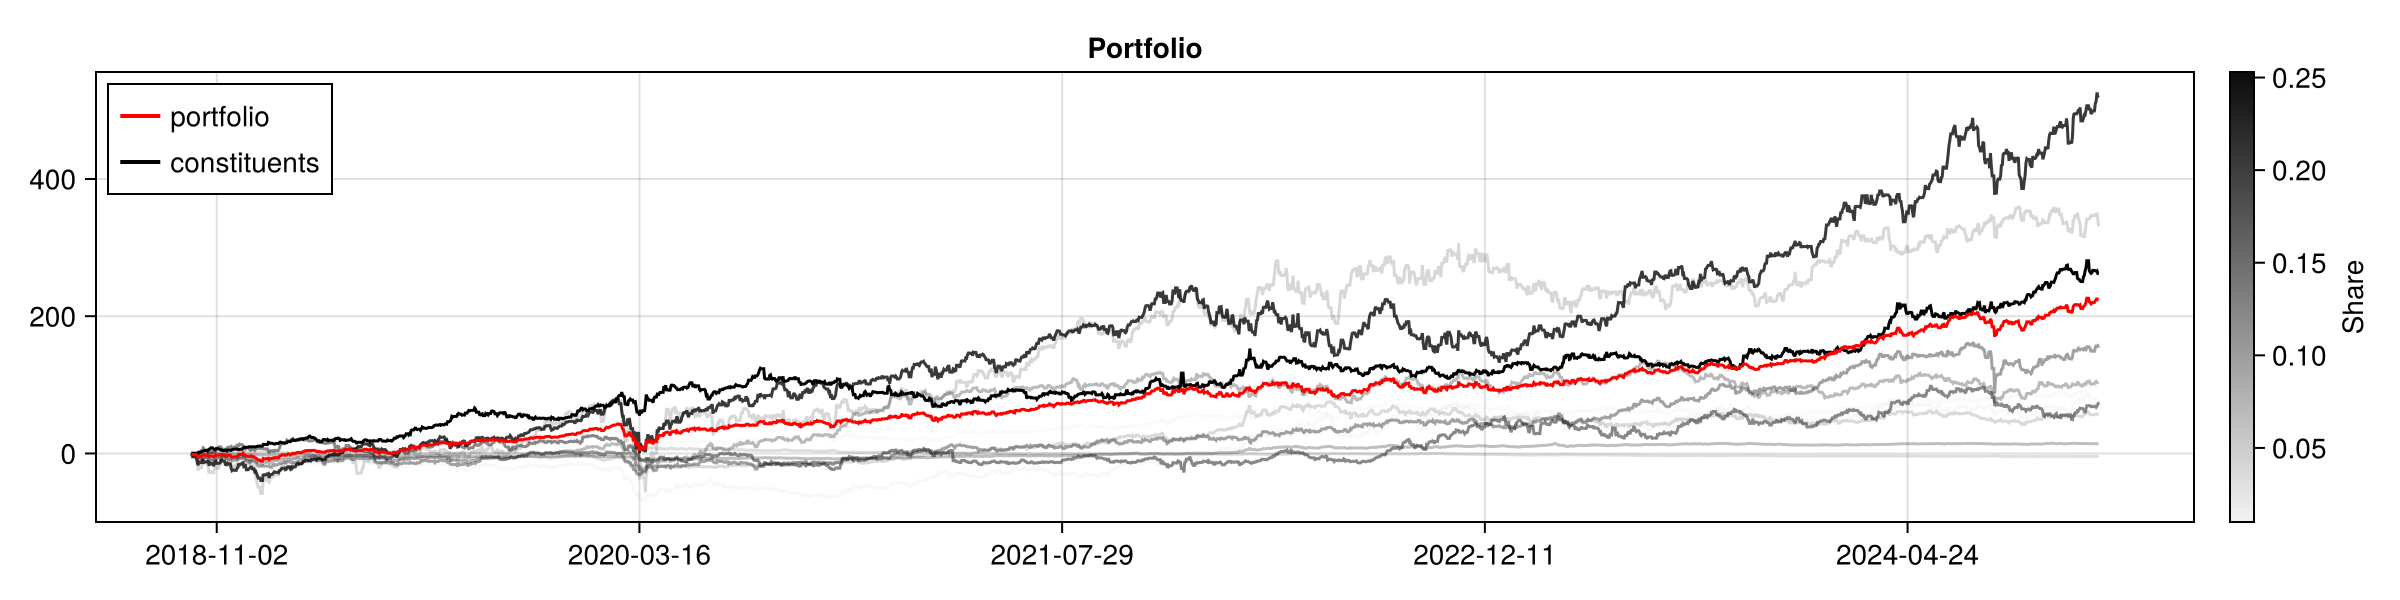

In [25]:
w_opt_round=round.(w_opt; digits=3);
share_color=(w_opt_round.-findmin(w_opt_round)[1])./(findmax(w_opt_round)[1]-findmin(w_opt_round)[1])

tickers_in_portfolio=DO_acc_cr.isin
DC_acc_cr_nrm=dropmissing(DC_acc_cr[:, ["date",tickers_in_portfolio...]])
mapcols!(x->x.-x[1].+100,DC_acc_cr_nrm; cols=Not("date"))

portfolio_value=sum(Matrix(reshape(w_opt_round,1,length(w_opt_round)).*DC_acc_cr_nrm[!,Not("date")]); dims=2)[:]

fig=Figure(;size=(1200,300))
ax=Axis(fig[1,1], title="Portfolio")

# Plot constituents first
constituent_line = nothing
for tk in names(DC_acc_cr_nrm)[2:end][w_opt_round.>1e-10]
    tk_ind=findfirst(x->x==tk,names(DC_acc_cr_nrm)[2:end])
    constituent_line = lines!(ax,DC_acc_cr_nrm[!,"date"], DC_acc_cr_nrm[!,tk].-100; color=(:black,share_color[tk_ind]))
end

# Plot portfolio
portfolio_line = lines!(ax,DC_acc_cr_nrm[!,"date"], portfolio_value.-100; color=:red)

# Add legend with explicit colors
axislegend(ax, [LineElement(linewidth=2, color=:red), LineElement(linewidth=2, color=:black)], ["portfolio", "constituents"], position=:lt)

# Add colorbar for shares
cbar = Colorbar(fig[1, 2], limits=(minimum(w_opt_round), maximum(w_opt_round)),
                colormap=Reverse(:grays), label="Share")

fig

Let us safe the result of the optimization together with the data used for it.

In [26]:
serialize("portfolio", Dict("overview_table"=>DO_acc_cr, "optimal_portfolio"=>w_opt, "USD_bound"=>USD_bound, "entropy_factor"=>entropy_factor, "lowest_share"=>lowest_share))

# Improvement ideas

## performance

1. Understand better the covariance matrix computation as now we are using it blindly.
2. For now we are using semi-global optimization technique. It does have a way to avoid local optima, however, there is no guarantee that it will not stuck there for sure. Can we do better?    
3. It would be nice to compare the perfromance of the optimized portfolio with its perturbations to understand how much of the deviation is tolerable and when one must do rebalancing.
   
## cosmetics

1. It would be nice to see the first and the last dates on the historical plot. 